# Enunciado
## Destino: Planeta VASS!
Por fin! El sistema que hemos creado ha terminado de analizar las características del planeta y se ha comprobado que es habitable. Después de un largo trayecto y varios inconvenientes, estamos a un paso de cumplir nuestro objetivo!

Este último paso es, probablemente, el más importante de todos, aterrizar en el planeta VASS.
Para asegurar el éxito del aterrizaje, hemos realizado una serie de experimentos en un espacio de simulación para predecir la manera más eficiente de aterrizar de forma segura.

Sin embargo, el simulador ha tenido problemas a la hora de determinar la eficiencia en algunos de los experimentos, por lo que ahora nuestro objetivo será analizar las simulaciones y determinar el nivel de eficiencia de aterrizaje de cada uno de los experimentos en los que falló. Tendremos que tener en cuenta las siguientes observaciones:

### Observaciones
- Cada uno de los experimentos cuenta con una serie pasos compuestos de estados y acciones de la nave de una simulación determinada.
- En cada paso el simulador genera un estado y decide una acción. El siguiente estado se verá determinado por esta acción, y a su vez se decidirá una nueva acción en base a ese nuevo estado, eso hasta que la simulación llegue a su fin.
- En cada paso, el simulador determina la contribución individual que ha tenido la acción tomada a la eficiencia total. Finalmente se calculan todas estas contribuciones para determinar la eficiencia total del experimento.
- La eficiencia es una función que utiliza internamente el simulador para determinar cuándo está tomando buenas decisiones. Esta función podría estar teniendo en cuenta los cambios que hay en los estados, así como las distintas acciones y variables.
- Las simulaciones se han realizado en diversas condiciones: gravedad, viento y turbulencias.
- CUIDADO! En algunas de las simulaciones los valores de la gravedad y viento no se guardaron correctamente, por lo que el sistema las ha registrado con un valor de 0.

Descarga los datos de los experimentos, analízalos y crea un modelo para predecir la eficiencia total de cada uno de los experimentos. Por último, observa los experimentos del conjunto de test que viene incluido en la descarga de los datos y envía las predicciones de los registros en el orden original separadas por comas, de la siguiente manera:

205.12,122.14,80.34,30.15,109.93

El ejemplo expuesto se correspondería con las predicciones de los 5 primeros registros, tendréis que subir en una sola línea las 2,000 predicciones usando este formato.

# How to land the Star Cruiser 42

## Context

This dataset contains information about simulations of landing a spaceship in a 2D environment.
This information can be used to determine the efficiency function in order to evaluate the best actions possible in a future landing.


## Metadata
Number of train files: 9513
Number of test files: 2000
Number of variables: 13
Target variable: efficiency


File variable details:

- x_pos # The position of the ship on the X axis, in units relative to the landing platform.
- y_pos # The position of the ship on the Y axis, in units relative to the landing platform.
- x_vel # Velocity of the ship on the X axis.
- y_vel # Velocity of the ship on the Y axis.
- angle # The angle of the spaceship in radians.
- ang_vel # The angular velocity of the spaceship.
- leg_1 # Boolean that represent whether leg 1 is in contact with the ground or not
- leg_2 # Boolean that represent whether leg 2 is in contact with the ground or not
- main_booster #  The throttle of the main engine.
- lat_booster # The throttle of the lateral boosters.

The first 6 variables determine the state and each step, and the last two (main_booster and lat_booster) are the actions taken in response
to that state, whose repercussions will be seen in the following step.

Experiment variable details:
- gravity # The magnitude of the gravity acceleration. A value of 0 means that the system didn't register the real value.
- wind_power # The maximum magnitude of linear wind applied to the spaceship. A value of 0 means that the system didn't register the real value.
- turbulences # The maximum magnitude of rotational wind applied to the spaceship.

Target variable detail
- efficiency # An internal function of the simulator to evaluate the quality of the landing.
    

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

import os, os.path
import errno

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !mkdir data
# !unzip /content/drive/MyDrive/datos\ \fase7.zip -d /content/data/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/data/train/experiment_4564.csv  
  inflating: /content/data/train/experiment_4565.csv  
  inflating: /content/data/train/experiment_4566.csv  
  inflating: /content/data/train/experiment_4567.csv  
  inflating: /content/data/train/experiment_4568.csv  
  inflating: /content/data/train/experiment_4569.csv  
  inflating: /content/data/train/experiment_4570.csv  
  inflating: /content/data/train/experiment_4571.csv  
  inflating: /content/data/train/experiment_4572.csv  
  inflating: /content/data/train/experiment_4575.csv  
  inflating: /content/data/train/experiment_4576.csv  
  inflating: /content/data/train/experiment_4577.csv  
  inflating: /content/data/train/experiment_4578.csv  
  inflating: /content/data/train/experiment_4579.csv  
  inflating: /content/data/train/experiment_458.csv  
  inflating: /content/data/train/experiment_4581.csv  
  inflating: /content/data/train/experiment_4582.csv  
  inf

# Experiments summary

In [4]:
# Open fase7/data/experiments_summary_test.xlsx and train
experiments_summary_test = pd.read_excel('data/experiments_summary_test.xlsx')
experiments_summary_train = pd.read_excel('data/experiments_summary_train.xlsx')

In [5]:
experiments_summary_train

,filename,total_timesteps,gravity,wind_power,turbulence_power,efficiency
0,experiment_1.csv,185,-5.375066,14.337393,1.902789,415.69
1,experiment_2.csv,428,-3.958084,16.376438,1.697932,104.37
2,experiment_4.csv,193,-3.640152,1.614948,0.192214,411.14
3,experiment_5.csv,166,0.000000,0.000000,0.242178,414.93
4,experiment_6.csv,172,-5.289123,15.771525,1.453806,373.85
...,...,...,...,...,...,...
9508,experiment_11506.csv,290,0.000000,0.000000,1.734030,413.52
9509,experiment_11507.csv,80,-9.777887,17.290063,1.830932,-765.06
9510,experiment_11508.csv,199,-5.563846,14.299549,1.971660,414.10
9511,experiment_11509.csv,115,0.000000,5.761313,1.203968,41.77


In [6]:
experiments_summary_test

,filename,total_timesteps,gravity,wind_power,turbulence_power
0,experiment_0.csv,156,-10.363594,9.555678,0.441689
1,experiment_3.csv,252,-2.599651,7.094931,0.772004
2,experiment_8.csv,146,-10.768399,5.744031,0.898704
3,experiment_10.csv,178,-7.815608,19.640269,1.631348
4,experiment_14.csv,193,-3.833533,11.007721,1.577970
...,...,...,...,...,...
1995,experiment_11478.csv,257,-5.879329,13.640501,0.986232
1996,experiment_11497.csv,845,-1.886632,0.843915,1.206717
1997,experiment_11505.csv,128,0.000000,5.633470,1.822572
1998,experiment_11511.csv,158,-10.947976,5.852086,1.298264


In [7]:
experiments_summary_train.describe()

,total_timesteps,gravity,wind_power,turbulence_power,efficiency
count,9513.000000,9513.000000,9513.000000,9513.000000,9513.000000
mean,224.807842,-5.671780,8.985153,0.998284,365.562140
std,117.874023,3.687404,6.227518,0.576618,201.228677
min,62.000000,-11.989907,0.000000,0.000089,-4280.660000
25%,160.000000,-8.853151,3.336993,0.503532,397.430000
50%,184.000000,-5.646706,8.888824,0.993838,407.420000
75%,244.000000,-2.633880,14.398609,1.500698,412.150000
max,996.000000,0.000000,19.996158,1.999953,425.600000


In [8]:
experiments_summary_test.describe()

,total_timesteps,gravity,wind_power,turbulence_power
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,222.474000,-5.832455,8.983764,0.992948
std,118.231555,3.695817,6.208299,0.573041
min,65.000000,-11.985971,0.000000,0.001034
25%,159.000000,-9.104783,3.329954,0.486418
50%,180.000000,-6.031826,8.929544,0.985516
75%,234.000000,-2.832137,14.161360,1.484154
max,951.000000,0.000000,19.999464,1.997806


In [9]:
experiments_summary = pd.concat([experiments_summary_train, experiments_summary_test], ignore_index=True)
experiments_summary.describe()

,total_timesteps,gravity,wind_power,turbulence_power,efficiency
count,11513.000000,11513.000000,11513.000000,11513.000000,9513.000000
mean,224.402415,-5.699692,8.984911,0.997357,365.562140
std,117.934382,3.689208,6.223914,0.575977,201.228677
min,62.000000,-11.989907,0.000000,0.000089,-4280.660000
25%,159.000000,-8.886684,3.331795,0.499894,397.430000
50%,184.000000,-5.730175,8.897582,0.993386,407.420000
75%,242.000000,-2.668897,14.352806,1.497393,412.150000
max,996.000000,0.000000,19.999464,1.999953,425.600000


Los datos con los que vamos a trabajar son experimentos que se componen por series temporales de longitud variable. Para un experimento i, contamos con un conjunto de datos de la forma (t_j, x_j), donde t_j es el timestamp y x_j el vector de variables.

Cada experimento i cuenta con:
- gravity
- wind_power
- tubulence_power
- eficciency

El vector de variables x_j está compuesto por las variables:
- x_pos
- y_pos
- x_vel
- y_vel
- angle
- ang_vel
- leg1
- leg2
- main_booster
- lat_booster


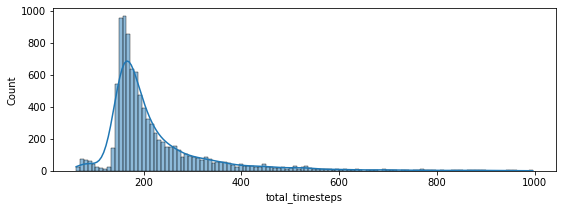

Skewness: 2.7097333474456917
Kurtosis: 9.403960196289452


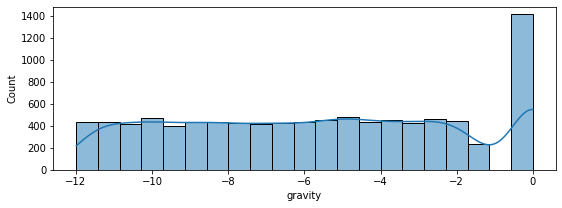

Skewness: 0.0401420069587474
Kurtosis: -1.1740127789158386


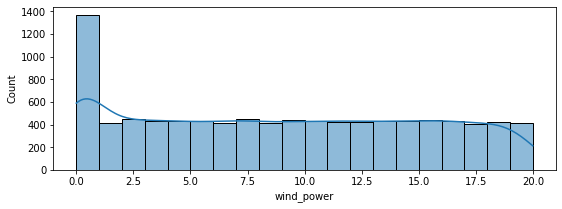

Skewness: 0.07695119224147386
Kurtosis: -1.2621910533002971


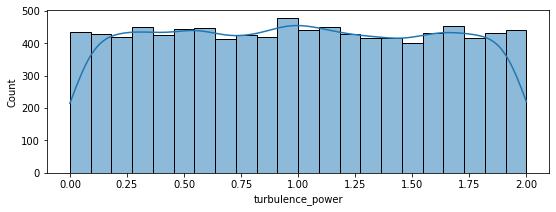

Skewness: 0.010665316623490222
Kurtosis: -1.1924621903124586


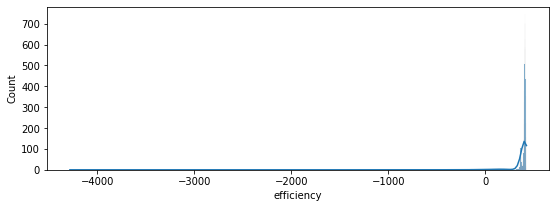

Skewness: -10.097286276431895
Kurtosis: 137.16759062025895


In [10]:
for col in experiments_summary_train.columns[1:]:
    fig = plt.figure(figsize=(9, 3))
    sns.histplot(data=experiments_summary_train, x=col, kde=True)
    plt.show()
    fig.clf()

    print('Skewness:', skew(experiments_summary_train[col]))
    print('Kurtosis:', kurtosis(experiments_summary_train[col]))

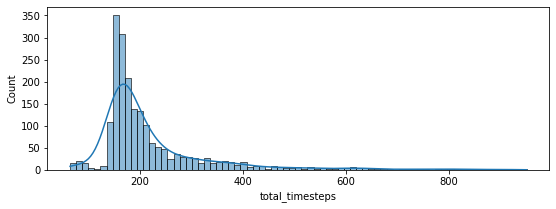

Skewness: 2.742135633358109
Kurtosis: 9.128657314846805


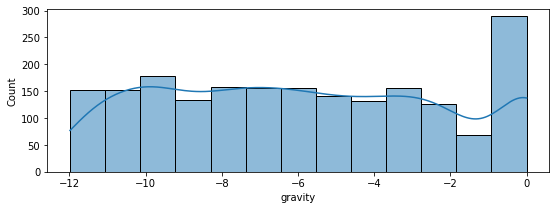

Skewness: 0.11420310856212346
Kurtosis: -1.1639227309503517


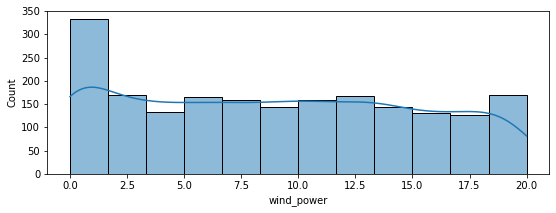

Skewness: 0.10474973690160508
Kurtosis: -1.2214878634974755


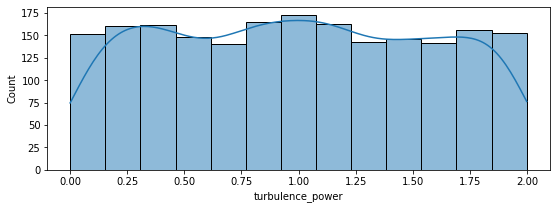

Skewness: 0.023880402596218944
Kurtosis: -1.177876908654558


In [11]:
for col in experiments_summary_test.columns[1:]:
    fig = plt.figure(figsize=(9, 3))
    sns.histplot(data=experiments_summary_test, x=col, kde=True)
    plt.show()
    fig.clf()

    print('Skewness:', skew(experiments_summary_test[col]))
    print('Kurtosis:', kurtosis(experiments_summary_test[col]))

In [12]:
for q in range(100):
    if np.percentile(experiments_summary_train['efficiency'], q) >= 0:
        print(q)
        break

3


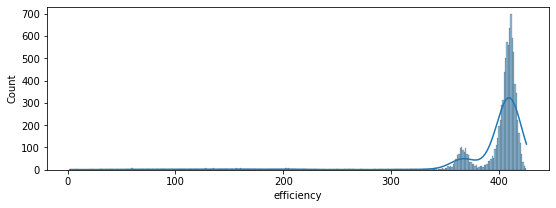

In [13]:
fig = plt.figure(figsize=(9, 3))
sns.histplot(data=experiments_summary_train[experiments_summary_train['efficiency'] > 0], x='efficiency', kde=True)
plt.show()
fig.clf()

In [14]:
for q in range(100):
    if np.percentile(experiments_summary_train['efficiency'], q) >= 350:
        print(q)
        break

9


Los dos conjuntos siguen la misma distribución para las variables como es de esperar, además de contar con los outliers comentados en el enunciado del ejercicio correspondientes al valor 0 para las variables gravity y wind_power.

Para la variable total_timesteps, podemos ver que aunque el 75% de las entradas tiene de un valor aproximadamente menor a 240 existen entradas que se extienden hasta los 900. 

Para la variable total_timesteps podemos ver que el 75% de las series cuenta con un timestamp menor a 242. El resto de casos se tratan de outliers, es decir, experimentos para los que el aterrizaje ha necesitado más tiempo. Esta variable se trata de una distribución de cola larga sesgada a la derecha.

Para las variables gravity y wind_power siguen una distribución uniforme, a excepción de las entradas con valor 0 para estas variables ya que se tratan de valores no registrados por el sistema.

Para la variable efficiency se observa una distribución de cola larga muy sesgada a la izquierda. El 3% de las entradas cuenta con un valor negativo para efficiency, por lo que la mayoría de entradas cuentan con un valor positivo para la variable. Además, un 91% de estas se encuentran entre 350 y 425.6.

In [15]:
def get_nans_experiments_summary(experiments_summary):
    gravity_nans = (experiments_summary['gravity'] == 0).sum()
    wind_power_nans = (experiments_summary['wind_power'] == 0).sum()
    gravity_wind_power_nans = ((experiments_summary[['gravity', 'wind_power']] == 0).sum(axis=1) == 2).sum()

    return gravity_nans, wind_power_nans, gravity_wind_power_nans

In [16]:
print(get_nans_experiments_summary(experiments_summary_train))
print(get_nans_experiments_summary(experiments_summary_test))

(1412, 948, 133)
(289, 190, 23)


# Experiments' series

In [17]:
def get_nans_experiments_series(series_path):
    nans_experiments = dict()

    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)

        nans_experiments[filename] = experiment_series.isnull().sum().sum()

    nans_experiments = pd.DataFrame.from_dict(nans_experiments, orient='index')
    nans_experiments = nans_experiments.reset_index()
    nans_experiments.columns = ['experiment', 'nans']
    return nans_experiments

In [18]:
train_series_path = 'data/train'
test_series_path = 'data/test'

train_series_nans = get_nans_experiments_series(train_series_path)
test_series_nans = get_nans_experiments_series(test_series_path)

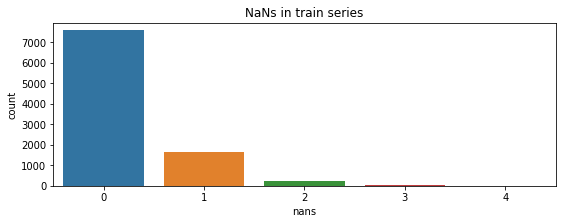

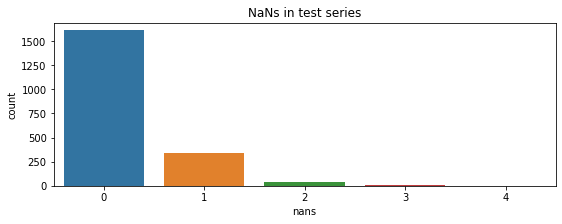

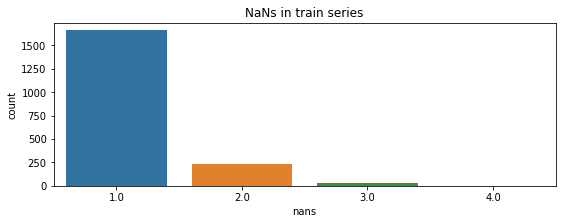

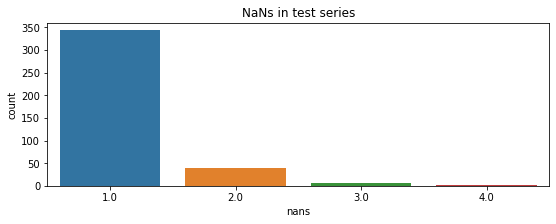

In [19]:
fig = plt.figure(figsize=(9, 3))
sns.countplot(data=train_series_nans, x='nans')
plt.title('NaNs in train series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=test_series_nans, x='nans')
plt.title('NaNs in test series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=train_series_nans[-(train_series_nans == 0)], x='nans')
plt.title('NaNs in train series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=test_series_nans[-(test_series_nans == 0)], x='nans')
plt.title('NaNs in test series')
plt.show()
fig.clf()

In [20]:
def get_experiments_stats(series_path):
    experiments_stats = dict()

    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)

        experiments_stats[filename] = {
            'x0_pos': experiment_series.iloc[0]['x_pos'],
            'y0_pos': experiment_series.iloc[0]['y_pos'],
            'xf_pos': experiment_series.iloc[-1]['x_pos'],
            'yf_pos': experiment_series.iloc[-1]['y_pos'],
            'total_main_booster': experiment_series['main_booster'].abs().sum(),
            'total_lat_booster': experiment_series['lat_booster'].abs().sum(),
            # 'leg_1': experiment_series.iloc[-1]['leg_1'],
            # 'leg_2': experiment_series.iloc[-1]['leg_2']
            'legs': experiment_series.iloc[-1]['leg_1'] + experiment_series.iloc[-1]['leg_2']
        }

    experiments_stats = pd.DataFrame.from_dict(experiments_stats, orient='index')
    experiments_stats = experiments_stats.reset_index()
    experiments_stats.columns = ['experiment', 'x0_pos', 'y0_pos', 'xf_pos', 'yf_pos', 'total_main_booster', 'total_lat_booster', 'legs']
    return experiments_stats

In [21]:
experiments_summary_train_stats = get_experiments_stats(train_series_path)
experiments_summary_test_stats = get_experiments_stats(test_series_path)

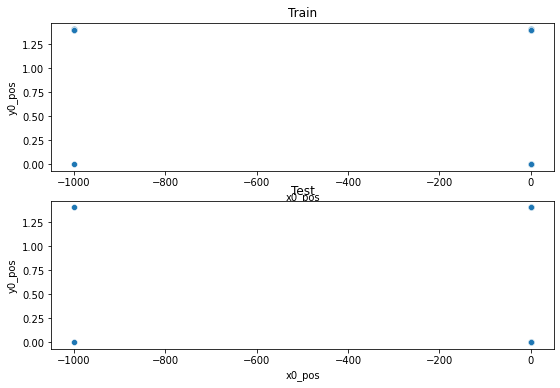

In [22]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.scatterplot(data=experiments_summary_train_stats, x='x0_pos', y='y0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.scatterplot(data=experiments_summary_test_stats, x='x0_pos', y='y0_pos')
plt.title('Test')
plt.show()

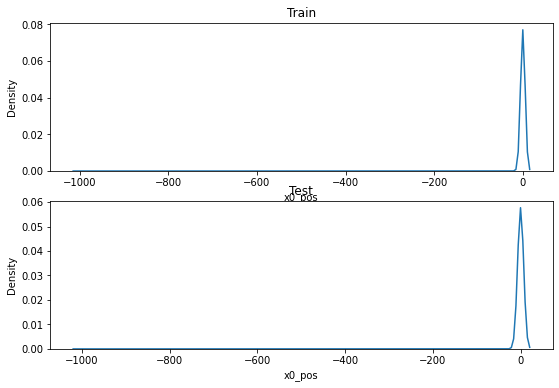

In [23]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='x0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='x0_pos')
plt.title('Test')
plt.show()

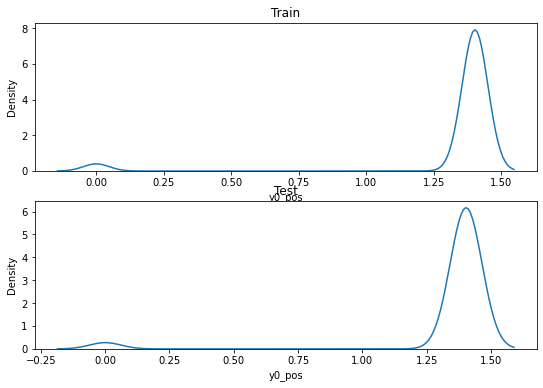

In [24]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='y0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='y0_pos')
plt.title('Test')
plt.show()

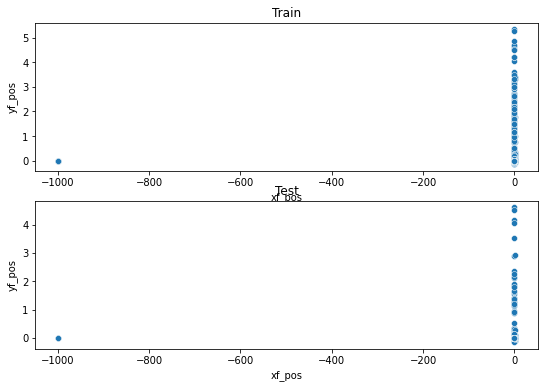

In [25]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.scatterplot(data=experiments_summary_train_stats, x='xf_pos', y='yf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.scatterplot(data=experiments_summary_test_stats, x='xf_pos', y='yf_pos')
plt.title('Test')
plt.show()

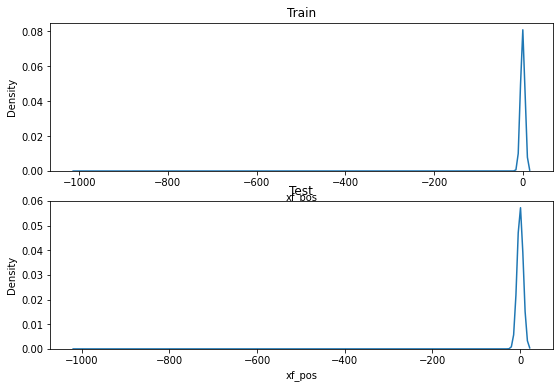

In [26]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='xf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='xf_pos')
plt.title('Test')
plt.show()

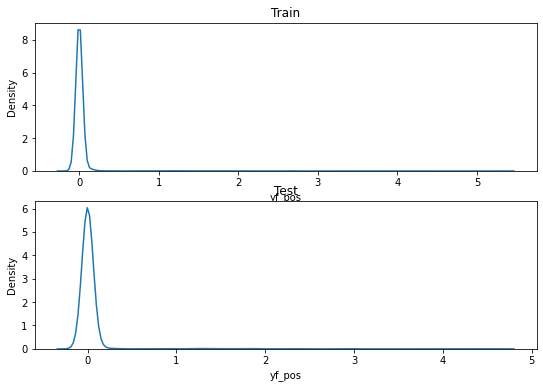

In [27]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='yf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='yf_pos')
plt.title('Test')
plt.show()

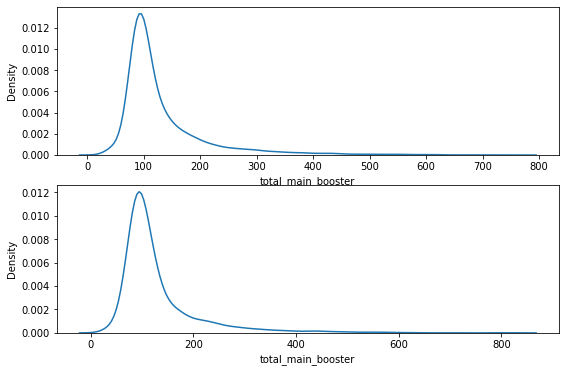

In [28]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='total_main_booster')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='total_main_booster')
plt.show()

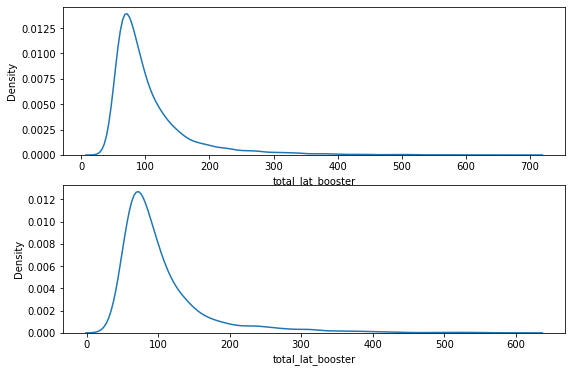

In [29]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='total_lat_booster')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='total_lat_booster')
plt.show()

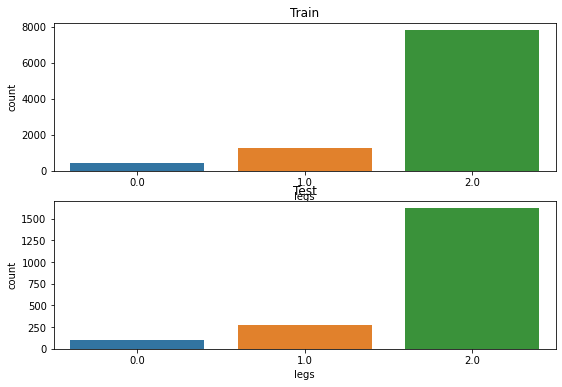

In [30]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.countplot(data=experiments_summary_train_stats, x='legs')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.countplot(data=experiments_summary_test_stats, x='legs')
plt.title('Test')
plt.show()

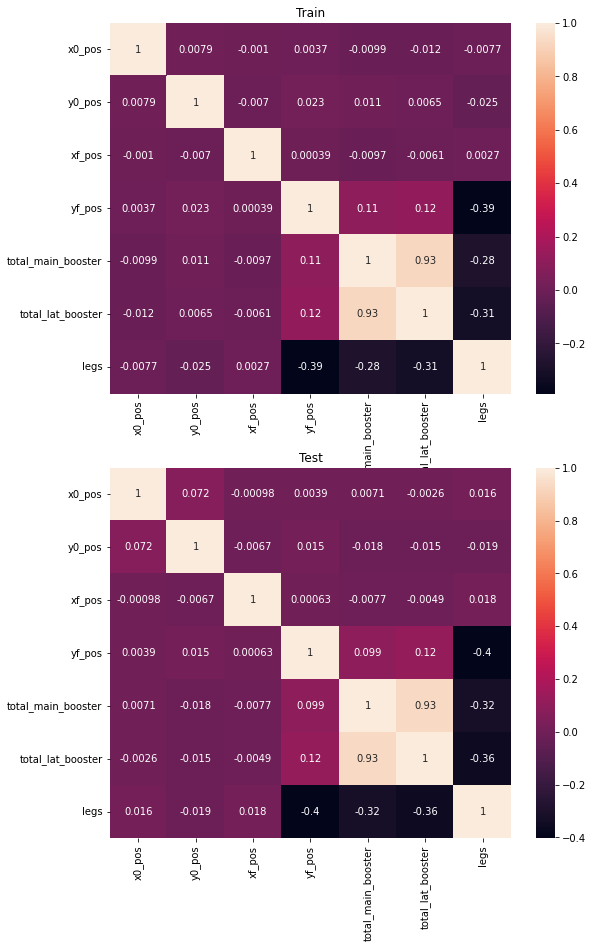

In [31]:
# sns heatmap of train and test correlations
fig = plt.figure(figsize=(9, 15))
ax1 = fig.add_subplot(211)
sns.heatmap(experiments_summary_train_stats.corr(), annot=True)
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.heatmap(experiments_summary_test_stats.corr(), annot=True)
plt.title('Test')
plt.show()

### Primera toma de contacto
Tiene pinta de ser un problema de aprendizaje por refuerzo (reinforcement learning), pero creo que también podría ser un problema de redes neuronales recurrentes.

#### Aprendizaje por refuerzo
El aprendizaje por refuerzo es una técnica de aprendizaje que consiste en una serie de iteraciones de entrenamiento, donde el objetivo es aprender a predecir el estado siguiente a partir del estado actual. https://es.wikipedia.org/wiki/Aprendizaje_por_refuerzo
![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/250px-Reinforcement_learning_diagram.svg.png "RL")


Pensandolo mejor, es un problema supervisado, por lo que no creo que sea un problema de aprendizaje por refuerzo, aunque sí parece que el "simulador" que genera estos experimentos internamente es una inteligencia artificial de Reinforcement Learning.
Nosotros lo que tenemos que hacer es aprender a predecir la valoración de todo el conjunto de acciones de cada experimento.

#### Idea de red neuronal recurrente
La idea de la red neuronal recurrente es que la red se comporte como una máquina de estados, y que cada vez que se ejecuta una acción, se guarda el estado actual en una matriz de estados, y se guarda la acción que se ha tomado en una matriz de acciones. Podríamos probar con una LSTM.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/300px-LSTM_Cell.svg.png "LSTM")

# Planteamiento como problema de aprendizaje por refuerzo (reinforcement learning)

Un problema de aprendizaje por refuerzo cuenta con los siguientes elementos:

- Estado: Situación del agente. En el problema se representa por las variables:
    - x_pos, y_pos
    - x_vel, y_vel
    - angle, angle_vel
    - leg1, leg2

- Acciones: Acciones que puede realizar el agente. En el problema se representan por las variables:
    - main_booster
    - lat_booster


- Entorno: Entorno en el que se encuentra el agente. En el problema se representa por las variables:
    - gravity
    - wind_power
    - turbulences

# Preprocessing

## Impute missing values in experiments summary

In [32]:
from sklearn.impute import KNNImputer

In [33]:
def knn_impute_summary_only(experiments_summary):
    experiments_summary_knn = experiments_summary[['total_timesteps', 'gravity', 'wind_power', 'turbulence_power']].copy()

    experiments_summary_knn.loc[experiments_summary_knn['gravity'] == 0, 'gravity'] = np.nan
    experiments_summary_knn.loc[experiments_summary_knn['wind_power'] == 0, 'wind_power'] = np.nan

    imputer = KNNImputer(n_neighbors=5)
    imputed_series = imputer.fit_transform(experiments_summary_knn.values)
    imputed_series = pd.DataFrame(imputed_series, columns=experiments_summary_knn.columns)
    imputed_series = imputed_series.set_index(experiments_summary_knn.index)

    experiments_summary_copy = experiments_summary.copy()
    experiments_summary_copy[['total_timesteps', 'gravity', 'wind_power', 'turbulence_power']] = imputed_series

    return experiments_summary_copy

In [34]:
experiments_summary_train_knn_imputed = knn_impute_summary_only(experiments_summary_train)
experiments_summary_test_knn_imputed = knn_impute_summary_only(experiments_summary_test)

In [35]:
print(get_nans_experiments_summary(experiments_summary_train_knn_imputed))
print(get_nans_experiments_summary(experiments_summary_test_knn_imputed))

(0, 0, 0)
(0, 0, 0)


In [36]:
experiments_summary_train_knn_imputed.to_excel('data/experiments_summary_train_knn_imputed.xlsx')
experiments_summary_test_knn_imputed.to_excel('data/experiments_summary_test_knn_imputed.xlsx')  

## Adding static fields to time series

In [37]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

def safe_open_w(path):
    mkdir_p(os.path.dirname(path))
    return open(path, 'w')

In [38]:
train_series_path = 'data/train'
test_series_path = 'data/test'
# train_experiments_summary_path = 'data/experiments_summary_train.xlsx'
# test_experiments_summary_path = 'data/experiments_summary_test.xlsx'
train_experiments_summary_path = 'data/experiments_summary_train_knn_imputed.xlsx'
test_experiments_summary_path = 'data/experiments_summary_test_knn_imputed.xlsx'

In [39]:
# Now that we have added the static variables (gravity, wind_power, turbulence_power)
# Create a numpy array of shape (samples, timesteps, features) from several csv files and assign each to the target variable (efficiency)
# - Load the data from the csv files
# - Create a numpy array of shape (samples, timesteps, features)
# - Assign each numpy array to a target variable
# - Return the target variable
def transform_data(series_path, experiments_summary_path, target_variable=None):
    experiments_summary = pd.read_excel(experiments_summary_path)
    experiments_summary = experiments_summary.set_index('filename')

    X = []
    y = []
    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)
        
        experiment_summary = experiments_summary.loc[filename]
        
        # Preprocessing steps
        # - Add static fields
        # - Remove NaNs
        # for static_var in ['gravity', 'wind_power', 'turbulence_power']:
        #    experiment_series[static_var] = np.repeat(experiment_summary[static_var], experiment_summary['total_timesteps']+1)
        
        # KNN imputation on NaNs
        # - Create a KNN imputer
        # - Fit the imputer on the data
        # - Transform the data
        # - Return the transformed data
        imputer = KNNImputer(n_neighbors=5)
        imputed_series = imputer.fit_transform(experiment_series.values)
        imputed_series = pd.DataFrame(imputed_series, columns=experiment_series.columns)
        imputed_series = imputed_series.set_index(experiment_series.index)
        
        # X.append(experiment_series.values)
        X.append(imputed_series.values)

        if target_variable is not None:
            y.append(experiment_summary[target_variable])
    
    if target_variable is not None:
        return np.array(X), np.array(y)
    else:
        return np.array(X)

train_X, train_y = transform_data(train_series_path, train_experiments_summary_path, 'efficiency')
test_X = transform_data(test_series_path, test_experiments_summary_path)

# Dump the data to a numpy files
np.save('data/train_X.npy', train_X)
np.save('data/train_y.npy', train_y)
np.save('data/test_X.npy', test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [40]:
# Load the data from the numpy files and transform it to (samples, timesteps, features)
train_X, train_y = np.load('data/train_X.npy', allow_pickle=True), np.load('data/train_y.npy', allow_pickle=True)
test_X = np.load('data/test_X.npy', allow_pickle=True)

In [41]:
print(train_X.dtype)
print(train_y.dtype)
print(test_X.dtype)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(train_X[0], train_y[0])

# Check nans in numpy arrays
print(pd.isnull(train_X).sum())
print(pd.isnull(train_y).sum())
print(pd.isnull(test_X).sum())

object
float64
object
(9513,) (9513,)
(217, 10) ()
[[-1.43108366e-03  1.40321100e+00 -1.45676702e-01 ...  0.00000000e+00
   2.94358522e-02  6.97216707e-01]
 [-2.67858501e-03  1.39553952e+00 -1.26251891e-01 ...  0.00000000e+00
  -3.98398516e-01 -8.26980841e-01]
 [-3.88488779e-03  1.38744760e+00 -1.23993911e-01 ...  0.00000000e+00
  -3.54503009e-01  9.01087549e-01]
 ...
 [-1.13046072e-01 -9.89546767e-04 -1.80334503e-08 ...  1.00000000e+00
  -8.85031819e-01 -1.84940100e-02]
 [-1.13046072e-01 -9.89546767e-04 -2.04733475e-08 ...  1.00000000e+00
  -7.70379901e-01 -1.97391033e-01]
 [-1.13046072e-01 -9.89546767e-04  0.00000000e+00 ...  1.00000000e+00
  -7.70379901e-01 -1.97391033e-01]] 396.14
0
0
0


In [42]:
# Pad the data to make it of the same length (max of all samples)
def pad_data(X):
    max_length = max([x.shape[0] for x in X])
    X_padded = []
    for x in X:
        x_padded = np.zeros((max_length, x.shape[1]))
        x_padded[:x.shape[0], :] = x
        X_padded.append(x_padded)
    return np.array(X_padded)

train_X = pad_data(train_X)
test_X = pad_data(test_X)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(test_X.shape)

(9513, 997, 10) (9513,)
(997, 10) ()
(2000, 952, 10)


In [43]:
def reshape_data_lstm(X):
    return X.reshape((X.shape[0], X[0].shape[0], X[0].shape[1]))

train_X = reshape_data_lstm(train_X)
test_X = reshape_data_lstm(test_X)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(test_X.shape)

(9513, 997, 10) (9513,)
(997, 10) ()
(2000, 952, 10)


In [44]:
train_X_static = pd.read_excel(train_experiments_summary_path)[['gravity', 'wind_power', 'turbulence_power']].values
test_X_static = pd.read_excel(test_experiments_summary_path)[['gravity', 'wind_power', 'turbulence_power']].values
print(train_X_static.shape, test_X_static.shape)

(9513, 3) (2000, 3)


## Scaling and imputing

# LSTM

Crearemos una red LSTM que reciba series temporales asociadas a cada uno de los experimentos. Estas series contarán con todos las variables asociadas al estado y las acciones del agente, además de introducir como nuevas variables las del entorno. Estas últimas tendrán el mismo valor para todos los pasos del experimento.

Dado que las distintas series son de longitud variable y se encuentran en distintos archivos csv, deberemos entrenar la red mediante mini batches de tamano 1 (cada uno de los experimentos de los archivos). Otra opción sería realizar padding sobre las series, pero al contar con un rango amplio de timesteps para las series además de contar con gran cantidad de valores atípicos no parece un enfoque adecuado.

In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Masking, Dropout, GRU, Bidirectional, Flatten, LayerNormalization
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import time
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

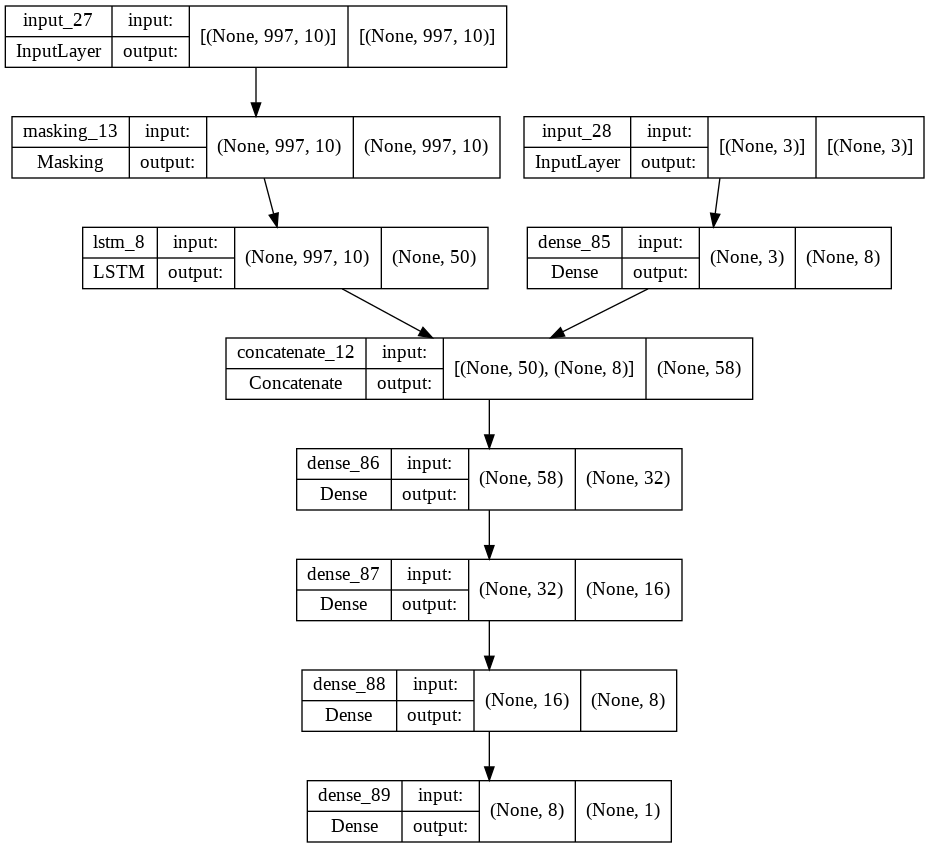

In [74]:
reset_random_seeds()

time_series_input_layer = tf.keras.Input(shape=(train_X.shape[1], train_X.shape[2]))
static_input_layer = tf.keras.Input(shape=(train_X_static.shape[1]))

masking_layer = Masking(mask_value=0.,)(time_series_input_layer)
lstm_layer = LSTM(50, activation='tanh', return_sequences=False)(masking_layer)

static_dense = Dense(8)(static_input_layer)

# Concatenate the static input layer with the LSTM layer
concatenated_layer = tf.keras.layers.concatenate([lstm_layer, static_dense])

dense_layer = Dense(32)(concatenated_layer)
dense_layer = Dense(16)(dense_layer)
dense_layer = Dense(8)(dense_layer)
dense_layer = Dense(1)(dense_layer)
model = tf.keras.Model(inputs=[time_series_input_layer, static_input_layer], outputs=dense_layer)
model.compile(loss='mean_absolute_error', optimizer='adam')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/500
119/119 - 9s - loss: 217.3802 - val_loss: 67.5080 - 9s/epoch - 76ms/step
Epoch 2/500
119/119 - 4s - loss: 45.8987 - val_loss: 31.8585 - 4s/epoch - 36ms/step
Epoch 3/500
119/119 - 4s - loss: 23.3108 - val_loss: 23.5446 - 4s/epoch - 36ms/step
Epoch 4/500
119/119 - 4s - loss: 20.0757 - val_loss: 22.2938 - 4s/epoch - 36ms/step
Epoch 5/500
119/119 - 4s - loss: 19.2483 - val_loss: 21.8577 - 4s/epoch - 36ms/step
Epoch 6/500
119/119 - 4s - loss: 18.7222 - val_loss: 21.3129 - 4s/epoch - 36ms/step
Epoch 7/500
119/119 - 4s - loss: 18.3297 - val_loss: 21.4899 - 4s/epoch - 36ms/step
Epoch 8/500
119/119 - 4s - loss: 17.9217 - val_loss: 21.1186 - 4s/epoch - 36ms/step
Epoch 9/500
119/119 - 4s - loss: 17.4929 - val_loss: 20.1059 - 4s/epoch - 36ms/step
Epoch 10/500
119/119 - 4s - loss: 17.0613 - val_loss: 20.7775 - 4s/epoch - 36ms/step
Epoch 11/500
119/119 - 4s - loss: 16.9507 - val_loss: 20.0215 - 4s/epoch - 36ms/step
Epoch 12/500
119/119 - 4s - loss: 16.4719 - val_loss: 20.0935 - 4s/epoch 

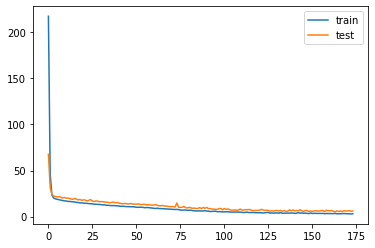

Time taken to train the model:  805.4369602203369


In [75]:
start_time = time.time()

# Train the model with early stopping.
history = model.fit(x=[train_X, train_X_static], y=train_y, epochs=500, batch_size=64, validation_split=0.2, verbose=2, shuffle=False, callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)])

print("Best val_loss for Early Stopping ", "epoch ", np.argmin(history.history['val_loss']) + 1, ": ", np.min(history.history['val_loss']))
# Plot the model's predictions
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

end_time = time.time()
print('Time taken to train the model: ', end_time - start_time)